In [76]:
import pandas as pd
import pathlib
import warnings
import seaborn as sns
import lightgbm as lgb
import numpy as np

warnings.filterwarnings("ignore")

%matplotlib inline

In [65]:
class Dataset:
    def __init__(self, data_dir, data_type="activity", remove_nulls=True):
        assert data_type in {"activity", "atactic"}
        self.data_path = pathlib.Path(data_dir)
        self.data_type = data_type
        self.remove_nulls = remove_nulls
        self.train_df = None
        self.test_df = None
        
    def _extract_datasets(self):
        train_data = pd.read_csv(
            self.data_path.joinpath("activity_train.csv.zip"),
            parse_dates=["date"], index_col="date",
            compression="zip"
        )
        test_data = pd.read_csv(
            self.data_path.joinpath("activity_test.csv.zip"),
            parse_dates=["date"], index_col="date",
            compression="zip"
        )
        
        data = pd.concat([train_data[test_data.columns], test_data])
        data.drop("f28", axis=1, inplace=True)

        if self.data_type == "activity":
            test_target_file = "activity_test_timestamps.csv"
            target_cols = ["activity"]
        else:
            test_target_file = "atactic_test_timestamps.csv"
            target_cols = ["atactic_1", "atactic_2", "atactic_3"]
            
        test_target = pd.read_csv(
            self.data_path.joinpath(test_target_file),
            index_col="date",
            parse_dates=["date"]
        )
        
        self.train_df = train_data[target_cols].join(data.shift(6, freq="H"))
        if self.remove_nulls:
            self.train_df = self.train[self.train.notnull().all(axis=1)]
            
        self.test_df = test_target.join(data.shift(6, freq="H")).ffill()
    
    @property
    def train(self):
        if self.train_df is None:
            self._extract_datasets()
            
        return self.train_df
    
    @property
    def test(self):
        if self.test_df is None:
            self._extract_datasets()
            
        return self.test_df
    
    @property
    def folds(self):
        dates = ["2018-08", "2018-09", "2018-10", "2018-11", "2018-12"]
        if self.data_type == "activity":
            target_cols = ["activity"]
        else:
            target_cols = ["atactic_1", "atactic_2", "atactic_3"]
            
        X = self.train_df.drop(target_cols, axis=1)
        y = self.train_df[target_cols]
    
        for dt in dates:
            train_idx, val_idx = (set(self.train_df[:dt].index), set(self.train_df[dt:].index))
            
            X_train, y_train = X[X.index.isin(train_idx)], y[y.index.isin(train_idx)]
            X_val, y_val = X[X.index.isin(val_idx)], y[y.index.isin(val_idx)]
            
            yield (X_train, y_train), (X_val, y_val)

In [81]:
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_pred-y_true)/y_true))

def make_submission(test_preds, date_index, file_path, target_cols):
    ts_preds = pd.DataFrame(test_preds, columns=target_cols, index=date_index)
    ts_preds.loc[date_index].to_csv(file_path)

In [66]:
dataset = Dataset("../data", data_type="activity")
train_df = dataset.train

train_df.head()

,activity,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13 14:30:00,32.449896,49.048771,294.933268,1.675466,0.000051,0.024688,0.001628,1.724180e+06,728860.217994,1.179884,...,335.67578,335.74625,336.91620,336.97977,342.95605,332.80826,332.81665,5493.318081,4829.339027,521.341026
2018-02-13 14:31:00,26.492102,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,...,335.66540,335.73734,336.98390,337.02980,342.97174,332.82263,332.78198,5247.641087,5020.168781,520.791888
2018-02-13 14:32:00,34.102710,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,...,335.63095,335.70050,336.97913,337.05157,342.97382,332.84164,332.82962,5000.878811,5207.399845,520.242810
2018-02-13 14:33:00,41.518222,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,...,335.57654,335.65533,337.00995,337.05280,342.97943,332.88272,332.88680,4751.941204,5387.604237,521.320522
2018-02-13 14:34:00,38.896862,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,...,335.53976,335.63748,337.05005,337.10764,342.98720,332.91257,332.90576,4513.198853,5566.278934,522.398114


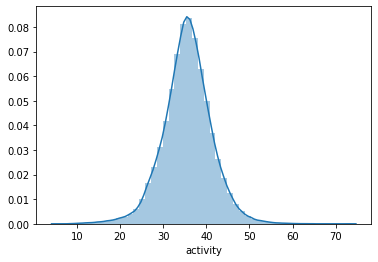

In [61]:
sns.distplot(train_df.activity)

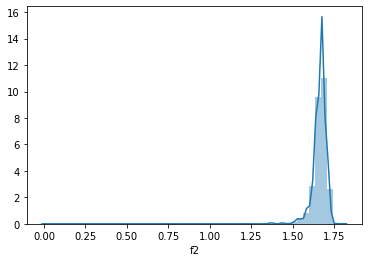

In [62]:
sns.distplot(train_df.f2)

In [87]:
model = lgb.LGBMRegressor(
    objective='regression',
    max_depth=3,
    learning_rate=0.05,
    n_estimators=1000,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.2319,
    feature_fraction_seed=9,
    bagging_seed=9,
    min_data_in_leaf=100,
    n_jobs=-1
)

test_preds = np.zeros(dataset.test.shape[0])
scores = []
fold_num = 0

for (X_train, y_train), (X_val, y_val) in dataset.folds:
    model.fit(X_train, y_train["activity"])
    preds = model.predict(X_val)

    score = mape(y_val["activity"], preds)
    scores.append(score)
    
    print(f"Fold #{fold_num} - MAPE {score}")
    
    test_preds += model.predict(dataset.test) / 5
    fold_num += 1

Fold #0 - MAPE 13.782641481990272
Fold #1 - MAPE 12.766715148158717
Fold #2 - MAPE 12.441928816967298
Fold #3 - MAPE 8.43026134397937
Fold #4 - MAPE 6.800915226915946


In [88]:
X = dataset.train.drop("activity", axis=1)
y = dataset.train.activity

model.fit(X, y)
final_preds = model.predict(dataset.test)

In [89]:
make_submission(final_preds, dataset.test.index, "lgb_baseline_1_full.csv", ["activity"])